<a href="https://colab.research.google.com/github/Butanium/coinrun-patchs/blob/main/coinrun_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is based on https://github.com/jbkjr/objective-robustness-failures by Lauro Langosco

# Setting up the environment (run once)
You just have to run this when you connect to a new environment

In [1]:
# Installing package to run coinrun (fix segfaults https://github.com/googlecolab/colabtools/issues/106)
import os
if 'LD_PRELOAD' in os.environ.keys():
  del os.environ['LD_PRELOAD']

In [2]:
%%capture
!apt-get remove libtcmalloc*
!apt-get update
!apt-get install mpich build-essential qt5-default pkg-config

In [3]:
# Download modified coinrun and model 
%%capture
!git clone --recursive https://github.com/jbkjr/objective-robustness-failures
%cd objective-robustness-failures/train-procgen-pytorch/ 
!mkdir model_data
!wget https://github.com/Butanium/coinrun-patchs/blob/main/data/coinrun.pth?raw=true -O model_data/coinrun.pth

In [4]:
%%capture
%pip install ipyplot pillow einops
!pip install gym3
%cd ../procgenAISC
!python setup.py install
%cd procgen
import os, sys
sys.path.append(os.getcwd())
%cd ../../train-procgen-pytorch

# ⚠️ Restart the environment (CTRL + M .) in order to have your path updated
After that you can run the rest of the code

In [1]:
DEVICE = "gpu"
%cd objective-robustness-failures/train-procgen-pytorch/

/content/objective-robustness-failures/train-procgen-pytorch


# Sanity check
You should be able to import the procgen module

In [2]:
import procgen

# CoinRun environment code and utils

## Imports

In [3]:
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy
from common import set_global_seeds, set_global_log_levels
from agents.base_agent import BaseAgent
from common.misc_util import adjust_lr, get_n_params

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
import json
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import einops

## Action space

In [4]:
env_actions = [("LEFT", "DOWN"),
            ("LEFT",),
            ("LEFT", "UP"),
            ("DOWN",),
            (),
            ("UP",),
            ("RIGHT", "DOWN"),
            ("RIGHT",),
            ("RIGHT", "UP"),
            ("D",),
            ("A",),
            ("W",),
            ("S",),
            ("Q",),
            ("E",),]
LEFT_DOWN = 0
LEFT = 1 
LEFT_UP = 2
DOWN = 3
NOOP = 4
UP = 5
RIGHT_DOWN = 6
RIGHT = 7
RIGHT_UP = 8
PRESS_D = 9
PRESS_A = 10
PRESS_W = 11
PRESS_S = 12
PRESS_Q = 13
PRESS_E = 14

def left_actions(env_actions):
    """
    Returns a list of all actions that move left.
    """
    return [i for i, action in enumerate(env_actions) if "LEFT" in action]

def right_actions(env_actions):
    """
    Returns a list of all actions that move right.
    """
    return [i for i, action in enumerate(env_actions) if "RIGHT" in action]

def opposite_action(action, env_actions):
    """
    Returns the opposite action of the given action.
    """
    if "LEFT" in env_actions[action]:
        if "DOWN" in env_actions[action]:
            return env_actions.index(("RIGHT", "UP"))
        elif "UP" in env_actions[action]:
            return env_actions.index(("RIGHT", "DOWN"))
        else:
            return env_actions.index(("RIGHT",))
    elif "RIGHT" in env_actions[action]:
        if "DOWN" in env_actions[action]:
            return env_actions.index(("LEFT", "UP"))
        elif "UP" in env_actions[action]:
            return env_actions.index(("LEFT", "DOWN"))
        else:
            return env_actions.index(("LEFT",))
    elif "UP" in env_actions[action]:
        return env_actions.index(("DOWN",))
    elif "DOWN" in env_actions[action]:
        return env_actions.index(("UP",))
    else:
        return env_actions.index(())
LEFT_ACTION_LIST = left_actions(env_actions)
RIGHT_ACTION_LIST = right_actions(env_actions)
DOWN_ACTION_LIST = [i for i, action in enumerate(env_actions) if "DOWN" in action]
UP_ACTION_LIST = [i for i, action in enumerate(env_actions) if "UP" in action]

## PPO agent
From Lauro's code but with an extra function to get the distribution and without the train code

In [5]:
class PPO(BaseAgent):
    def __init__(self,
                 env,
                 policy,
                 logger,
                 storage,
                 device,
                 n_checkpoints,
                 env_valid=None,
                 storage_valid=None,
                 n_steps=128,
                 n_envs=8,
                 epoch=3,
                 mini_batch_per_epoch=8,
                 mini_batch_size=32*8,
                 gamma=0.99,
                 lmbda=0.95,
                 learning_rate=2.5e-4,
                 grad_clip_norm=0.5,
                 eps_clip=0.2,
                 value_coef=0.5,
                 entropy_coef=0.01,
                 normalize_adv=True,
                 normalize_rew=True,
                 use_gae=True,
                 **kwargs):

        super(PPO, self).__init__(env, policy, logger, storage, device,
                                  n_checkpoints, env_valid, storage_valid)

        self.n_steps = n_steps
        self.n_envs = n_envs
        self.epoch = epoch
        self.mini_batch_per_epoch = mini_batch_per_epoch
        self.mini_batch_size = mini_batch_size
        self.gamma = gamma
        self.lmbda = lmbda
        self.grad_clip_norm = grad_clip_norm
        self.eps_clip = eps_clip
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.normalize_adv = normalize_adv
        self.normalize_rew = normalize_rew
        self.use_gae = use_gae

    def predict(self, obs, hidden_state, done):
        with torch.no_grad():
            obs = torch.FloatTensor(obs).to(device=self.device)
            hidden_state = torch.FloatTensor(hidden_state).to(device=self.device)
            mask = torch.FloatTensor(1-done).to(device=self.device)
            dist, value, hidden_state = self.policy(obs, hidden_state, mask)
            act = dist.sample()
            log_prob_act = dist.log_prob(act)
        return act.cpu().numpy(), log_prob_act.cpu().numpy(), value.cpu().numpy(), hidden_state.cpu().numpy()
    def predict_with_logits(self, obs, hidden_state, done):
      with torch.no_grad():
          obs = torch.FloatTensor(obs).to(device=self.device)
          hidden_state = torch.FloatTensor(hidden_state).to(device=self.device)
          mask = torch.FloatTensor(1-done).to(device=self.device)
          dist, value, hidden_state = self.policy(obs, hidden_state, mask)
          act = dist.sample()
          log_prob_act = dist.log_prob(act)

      return act.cpu().numpy(), log_prob_act.cpu().numpy(), dist.logits.cpu().numpy(), value.cpu().numpy(), hidden_state.cpu().numpy()


## Load agent
Legacy from Lauro's code


In [6]:
def load_env_and_agent(exp_name,
                       num_envs,
                       model_file,
                       start_level,
                       num_levels,
                       distribution_mode="hard",
                       param_name="hard",
                       device=DEVICE,
                       gpu_device=0,
                       random_percent=0,
                       logdir=None,
                       num_threads=10):

    env_name = "coinrun"

    ####################
    ## HYPERPARAMETERS #
    ####################
    with open('hyperparams/procgen/config.yml', 'r') as f:
        hyperparameters = yaml.safe_load(f)[param_name]

    ############
    ## DEVICE ##
    ############
    if device == 'gpu':
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    #################
    ## ENVIRONMENT ##
    #################
    def create_venv(hyperparameters):
        venv = ProcgenEnv(num_envs=num_envs,
                        env_name=env_name,
                        num_levels=num_levels,
                        start_level=int(start_level),
                        distribution_mode=distribution_mode,
                        num_threads=num_threads,
                        random_percent=random_percent)
        venv = VecExtractDictObs(venv, "rgb")
        normalize_rew = hyperparameters.get('normalize_rew', True)
        if normalize_rew:
            venv = VecNormalize(venv, ob=False) # normalizing returns, but not
            #the img frames
        venv = TransposeFrame(venv)
        venv = ScaledFloatFrame(venv)
        return venv
    n_steps = hyperparameters.get('n_steps', 256)

    env = create_venv(hyperparameters)

    ############
    ## LOGGER ##
    ############
    logger = Logger(num_envs, "./logs")

    ###########
    ## MODEL ##
    ###########
    observation_space = env.observation_space
    observation_shape = observation_space.shape
    architecture = hyperparameters.get('architecture', 'impala')
    in_channels = observation_shape[0]
    action_space = env.action_space

    # Model architecture
    if architecture == 'nature':
        model = NatureModel(in_channels=in_channels)
    elif architecture == 'impala':
        model = ImpalaModel(in_channels=in_channels)

    # Discrete action space
    recurrent = hyperparameters.get('recurrent', False)
    if isinstance(action_space, gym.spaces.Discrete):
        action_size = action_space.n
        policy = CategoricalPolicy(model, recurrent, action_size)
    else:
        raise NotImplementedError
    policy.to(device)

    #############
    ## STORAGE ##
    #############
    hidden_state_dim = model.output_dim
    storage = Storage(observation_shape, hidden_state_dim, n_steps, num_envs, device)

    ###########
    ## AGENT ##
    ###########
    algo = hyperparameters.get('algo', 'ppo')
    if algo == 'ppo':
        AGENT = PPO
    else:
        raise NotImplementedError
    agent = AGENT(env, policy, logger, storage, device, 0, **hyperparameters)

    agent.policy.load_state_dict(torch.load(model_file, map_location=device)["model_state_dict"])
    agent.n_envs = num_envs
    return agent

In [7]:
def load_episode(exp_name, level_seed, model_file, **kwargs):
    """Load a single coinrun level with fixed seed. Same level layout after reset
    logdir is just for agent logs."""
    return load_env_and_agent(
        exp_name=exp_name,
        num_envs=1,
        model_file=model_file,
        num_levels=1,
        start_level=level_seed,
        num_threads=1, **kwargs
       )

## Hook abstract class

In [8]:
from abc import ABC, abstractmethod

class Hook(ABC):
  @abstractmethod
  def __call__(self, obs: np.ndarray,  hidden_state, agent):
    return obs, hidden_state

## CoinRun code
Legacy from Lauro's code


In [9]:
def run_env(
    exp_name,
    model_file,
    level_seed,
    hook : Hook = None,
    logfile=None,
    reset_mode="off", 
    max_num_timesteps=10_000,
    save_value=False,
    **kwargs):
    """
    Runs one coinrun level.
    Reset modes:
        - inv_coin returns when agent gets the inv coin OR finishes the level
        - complete returns when the agent finishes the level
        - off resets only when max_num_timesteps is reached (repeating always the same level)
    
    returns level metrics. If logfile (csv) is supplied, metrics are also
    appended there.
    """
    if save_value:
        raise NotImplementedError
    append_to_csv = False
    if logfile is not None:
        append_to_csv = True

    agent = load_episode(exp_name, level_seed, model_file, **kwargs)
    
    obs = agent.env.reset()
    hidden_state = np.zeros((agent.n_envs, agent.storage.hidden_state_size))
    done = np.zeros(agent.n_envs)


    def log_to_csv(metrics):
        """write metrics to csv"""
        if not metrics:
            return
        column_names = ["seed", "steps", "rand_coin", "coin_collected", "inv_coin_collected", "died", "timed_out"]
        metrics = [int(m) for m in metrics]
        if append_to_csv:
            with open(logfile, "a") as f:
                w = csv.writer(f)
                if f.tell() == 0: # write header first
                    w.writerow(column_names)
                w.writerow(metrics)


    def log_metrics(done: bool, info: dict):
        """
        When run complete, log metrics in the 
        following format:
        seed, steps, randomize_goal, collected_coin, collected_inv_coin, died, timed_out
        """
        metrics = None
        if done:
            keys = ["prev_level_seed", "prev_level/total_steps", "prev_level/randomize_goal", "prev_level_complete", "prev_level/invisible_coin_collected"]
            # Fix unbound key error TODO: why is /total_steps not set ?
            keys = [k for k in keys if k in info.keys()]
            metrics = [info[key] for key in keys]
            if info["prev_level_complete"]:
                metrics.extend([False, False])
            else:
              pass
                # timed_out = info["prev_level/total_steps"] > 999
                # metrics.extend([not timed_out, timed_out])
        elif info["invisible_coin_collected"]:
            keys = ["level_seed", "total_steps", "randomize_goal"]
            metrics = [info[key] for key in keys]
            metrics.extend([-1, True, -1, -1])
        else:
            raise
        if append_to_csv:
          log_to_csv(metrics)
        return metrics


    def check_if_break(done: bool, info: dict):
        if reset_mode == "inv_coin":
            return done or info["invisible_coin_collected"]
        elif reset_mode == "complete":
            return done
        elif reset_mode == "off":
            return False
        else:
            raise ValueError("Reset mode must be one of inv_coin, complete, off."
                             f"Instead got {reset_mode}")

    step = 0
    if hook is None:
      hook = lambda obs, *args : obs
    while step < max_num_timesteps:
        agent.policy.eval()
        for _ in range(agent.n_steps):  # = 256
            step += 1
            hooked_obs, hooked_state = hook(obs, hidden_state, agent)
            if hooked_obs.shape != obs.shape:
              raise ValueError("your hook changes the obs shape")
            obs, hidden_state = hooked_obs, hooked_state
            act, log_prob_act, value, next_hidden_state = agent.predict(obs, hidden_state, done)
            next_obs, rew, done, info = agent.env.step(act)

            agent.storage.store(obs, hidden_state, act, rew, done, info, log_prob_act, value)
            hidden_state = next_hidden_state
            obs = next_obs

            if check_if_break(done[0], info[0]):
                log_metrics(done[0], info[0])
                return
    return


## Utils

In [10]:
import matplotlib.pyplot as plt
import ipyplot
from PIL import Image
# Activate widgets in google colab
import ipywidgets as widgets
import IPython.display as display
from google.colab import output
output.enable_custom_widget_manager()


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [44]:
def plot_images(img_arrays, max_images=20, img_width=15):
  ipyplot.plot_images(img_arrays, max_images=max_images, img_width=img_width)
def plot_obs(obs, **kwargs):
  return plot_img(obs_to_img(obs), **kwargs)
def obs_to_img(obs):
  return np.uint8(np.einsum('cwh -> whc', obs)* 255)
def plot_img(img, size=(250,250)):
  display.display(Image.fromarray(img).resize(size))
def slider_of_imgs(imgs,  hook=None):
  min_val = 0
  max_val = len(imgs) - 1

  # Create a slider widget
  slider = widgets.IntSlider(min=min_val, max=max_val, continuous_update=True)

  # Define a function to display the current image based on the slider value
  def on_value_change(change):
      index = change['new']
      img_array = imgs[index]
      # Create a PIL image from the numpy array
      img = Image.fromarray(np.uint8(img_array)).resize((250,250))
      # Display the image
      display.clear_output(wait=True)
      if hook is not None:
        hook(index)
      display.display(img)
      display.display(slider)

  # Call the on_value_change function when the slider value changes
  slider.observe(on_value_change, names='value')

  # Display the initial image
  if hook is not None:
    hook(0)
  display.display(Image.fromarray(np.uint8(imgs[0])).resize((250,250)))
  # Display the slider widget
  display.display(slider)
def slider_of_obs(obs_list, **kwargs):
  slider_of_imgs(list(map(obs_to_img, obs_list)), **kwargs)


# Image patching

In [66]:
def patched_img(img, pos, patch, no_error=False):
  # Check if the position is valid
  if pos[0] < 0 or pos[0] >= img.shape[1] or pos[1] < 0 or pos[1] >= img.shape[2]:
    if no_error:
      return None
    raise ValueError("invalid position")
  # Check if the patch is valid
  if pos[0] + patch.shape[1] > img.shape[1] or pos[1] + patch.shape[2] > img.shape[2]:
    if no_error:
      return None
    raise ValueError("invalid position / dim")
  img = deepcopy(img)
  img[:, pos[0]:pos[0] + patch.shape[1], pos[1]:pos[1] + patch.shape[2]] = patch
  return torch.tensor(img, dtype=float)

def get_all_patched(img, pos, patchs):
  return list(map(lambda p : patched_img(img, pos, p), patchs))

def get_patch(img, pos, dim):
  x,y = pos[0], pos[1]
  return img[:, x:x + dim[0], y:y + dim[1]]

def patch_all_pos(obs, patch):
    patched_list = []
    for i in range(obs.shape[1]):
      for j in range(obs.shape[2]):
        patched = patched_img(obs, (i,j), patch, no_error=True)
        if patched is not None:
          patched_list.append(patched)
    return torch.stack(patched_list)
class Patcher:
  def __init__(self, dataset, agent):
    self.dataset = dataset
    self.agent = agent

  
        
       
  def eval_patched(self, patched, hidden_state, device=DEVICE):
      obs = patched.float()
      with torch.no_grad():
        return self.agent.predict_with_logits(obs, hidden_state, False)[:-1]

  def eval_patchs(self, img, patchs, hidden_state, pos, n=10, device = DEVICE):
    # create batch of patched images
    """
int DISCRETE_ACTIONS[NUM_ACTIONS * 2] = {
    0, 0,
    +1, 0,  // right
    -1, 0,  // left
    0, +1,  // jump
    +1, +1, // right-jump
    -1, +1, // left-jump
    0, -1,  // down  (step down from a crate)
};
   
    """
    # todo better memory use
    # if device == 'gpu':
    #     device = torch.device('cuda')
    # else:
    #     device = torch.device('cpu')
    imgs = torch.stack(get_all_patched(img, pos, patchs))
    # imgs = get_all_patched(img, pos, patchs)  
    obs = imgs.float()
    init_obs = torch.unsqueeze(torch.tensor(img).float(), dim=0)
    
    with torch.no_grad():
      return obs,self.agent.predict_with_logits(obs, hidden_state, False)[:-1],\
        self.agent.predict_with_logits(init_obs, hidden_state, False)[:-1]
     

      


  def create_patchs(self, dim, patch_per_image, dataset_stride=1):
    """
    Create patchs from a dataset
    :param dim: dimension of the patch
    :param patch_per_image: the amount of patch per image
    :param dataset_stride: dataset // dataset_stride images will be used
    :return: a list of patchs
    """
    patchs = []
    d_size = len(self.dataset)
    start = random.randint(0, min(d_size, dataset_stride) - 1)
    for i in range(start, d_size, dataset_stride):
      img = self.dataset[i]
      if patch_per_image is None:
        for x in range(0, img.shape[1] - dim[0]):
          for y in range(0, img.shape[2] - dim[1]):
            patchs.append(img[:, x:x + dim[0], y:y + dim[1]])
      else:
        for _ in range(patch_per_image):
          x = random.randint(0, img.shape[1] - dim[0])
          y = random.randint(0, img.shape[2] - dim[1])
          patchs.append(img[:, x:x + dim[0], y:y + dim[1]])
    return patchs

# Experiments

## Collect data with a hook

In [13]:
class ObsHook(Hook):
  def __init__(self, saveRate : int):
    self.saveRate = saveRate
    self.current = 0
    self.saves = []
    self.states_save = []
    self.agent = None
  
  def __call__(self, obs : np.ndarray, hidden_state, agent):
      if self.agent is None:
        self.agent = agent
      self.current += 1
      if self.current >= self.saveRate:
        self.current = 0
        self.saves.append(obs)
        self.states_save.append(hidden_state)
      return obs, hidden_state

  def end(self):
    plotable = list(map(lambda obs : obs_to_img(obs[0]), self.saves))
    self.plotable = np.array(plotable)
    slider_of_imgs(self.plotable) 

115 steps


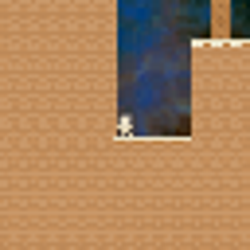

IntSlider(value=0, max=114)

In [14]:
hook = ObsHook(1)
run_env("test experiment", "model_data/coinrun.pth", 0xc0ffee, hook=hook, max_num_timesteps=1000, reset_mode="complete")
print(f"{len(hook.saves)} steps")
obs_list = np.array(hook.saves)[:, 0]
agent = hook.agent
hidden_states = hook.states_save
hook.end()

## Test patching

In [49]:
patch_pos = (40,45)
patch_size = (15, 15)
obs_index = 30

In [45]:
coin_patch = get_patch(obs_list[-1], (30, 35), (5,5))
plot_obs(coin_patch, size=(5,5))

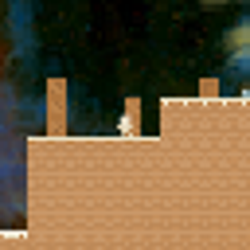

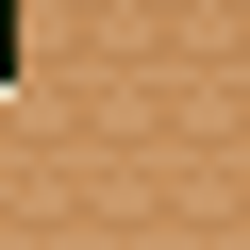

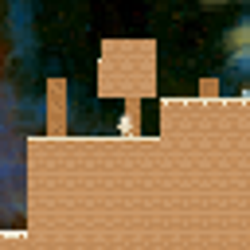

In [23]:
img = obs_list[obs_index]
patch = get_patch(img, (30,40), patch_size)
plot_img(obs_to_img(img))
plot_img(obs_to_img(patch))
patched = patched_img(img, patch_pos, patch)
plot_img(obs_to_img(patched))

## Best patchs

In [62]:
patcher = Patcher(obs_list, agent)
patchs = patcher.create_patchs(patch_size, patch_per_image=None)
print(f"we got {len(patchs)} patchs!")
frame = obs_list[obs_index]
hidden_state = hidden_states[obs_index]
sel_patchs = random.choices(patchs, k=100) + patchs[len(patchs)-1000:] + [coin_patch]
patched_images, patchs_res, img_res = patcher.eval_patchs(frame, sel_patchs, hidden_state, patch_pos)
(actions, log_prob_acts, logits, values), \
(init_action, init_log_prob, init_logits, init_value)= (patchs_res, img_res)
best_actions = np.argmax(logits, axis=-1)
init_logits = init_logits[0]
init_best = np.argmax(init_logits)
indexed_images = list(zip(patched_images, range(len(patched_images))))

we got 276115 patchs!


### Patchs that augment the go left logits

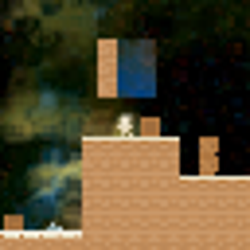

init action: ('RIGHT', 'DOWN')
left diff score : 12.39
best action: ('RIGHT', 'DOWN')


IntSlider(value=0, max=9)

In [ ]:
def left_diff(act_logits):
  return sum(act_logits[LEFT_ACTION_LIST]) - sum(init_logits[LEFT_ACTION_LIST])\
  -sum(act_logits[RIGHT_ACTION_LIST])
key = lambda t : left_diff(logits[t[1]])
indexed_images.sort(key = key, reverse=True)
def hook_fun(i):
  print(f"init action: {env_actions[init_best]}")
  print("left diff score : %.2f" % key(("_",indexed_images[i][1])))
  print(f"best action: {env_actions[best_actions[i]]}")
slider_of_obs([i[0] for i in indexed_images[:10]], hook=hook_fun)

### Patchs that augment the go UP logits

init action: ('RIGHT', 'DOWN')
left diff score : 9.51
best action: ('RIGHT', 'DOWN')


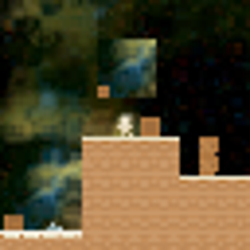

IntSlider(value=7, max=9)

In [ ]:
def top_diff(act_logits):
  return sum(act_logits[UP_ACTION_LIST]) - sum(init_logits[UP_ACTION_LIST])\
  -sum(act_logits[RIGHT_ACTION_LIST])
key = lambda t : left_diff(logits[t[1]])
indexed_images.sort(key = key, reverse=True)
def hook_fun(i):
  print(f"init action: {env_actions[init_best]}")
  print("up diff score : %.2f" % key(("_",indexed_images[i][1])))
  print(f"best action: {env_actions[best_actions[i]]}")
slider_of_obs([i[0] for i in indexed_images[:10]], hook=hook_fun)

### Patchs that don't go right

In [47]:
change_tuples = [i for i in indexed_images if best_actions[i[1]] not in  [RIGHT, RIGHT_DOWN]]
change_obs = [obs for obs,i in change_tuples]
slider_of_obs(change_obs, hook=lambda i : print(f"chosen action {env_actions[best_actions[change_tuples[i][1]]]}"))

TraitError: ignored

### Patch that increase the expected value

init action: ('RIGHT',), init value: [7.192669]
value diff : -0.02
best action: ('RIGHT',)


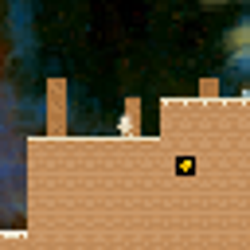

IntSlider(value=0, max=0)

In [51]:
key = lambda t : values[t[1]]
indexed_images.sort(key = key, reverse=True)
def hook_fun(i):
  print(f"init action: {env_actions[init_best]}, init value: {init_value}")
  print("value diff : %.2f" % (key(indexed_images[i])-init_value))
  print(f"best action: {env_actions[best_actions[i]]}")
slider_of_obs([i[0] for i in indexed_images[:10]], hook=hook_fun)

### check coin influence

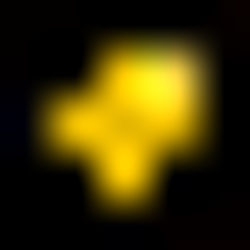

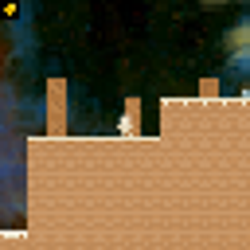

IntSlider(value=0, max=3599)

In [69]:
patched_imgs2 = patch_all_pos(frame, coin_patch)
plot_obs(coin_patch)
slider_of_obs(patched_imgs2)
patchs_res2 = patcher.eval_patched(patched_imgs2, hidden_state, patch_pos)
(actions, log_prob_acts, logits, values)= patchs_res2
best_actions_coin = np.argmax(logits, axis=-1)
indexed_images2 = list(zip(patched_imgs2, range(len(patched_imgs2))))

init action: ('RIGHT',), init value: [7.192669]
value diff : 1.66
best action: ('RIGHT', 'DOWN')


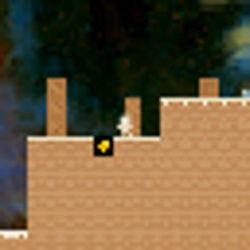

IntSlider(value=9, max=9)

In [72]:
key = lambda t : values[t[1]]
indexed_images2.sort(key = key, reverse=True)
def hook_fun(i):
  print(f"init action: {env_actions[init_best]}, init value: {init_value}")
  print("value diff : %.2f" % (key(indexed_images2[i])-init_value))
  print(f"best action: {env_actions[best_actions[i]]}")
slider_of_obs([i[0] for i in indexed_images2[:10]], hook=hook_fun)